<a href="https://colab.research.google.com/github/EmoDetect/emodetect/blob/main/EmotionsKids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("hello")

hello


In [54]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
### CNN models ###
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from keras.layers.normalization.batch_normalization import BatchNormalization
from tensorflow.keras import models
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D,concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

Parameters

In [55]:
batch_size = 32
num_epochs = 50
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
base_path = 'models/'
shape_x = 48
shape_y = 48
image_size=(48,48)
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

Data

In [83]:
data=pd.read_csv('/content/sample_data/fer2013/fer2013.csv')
print(len(data))
# data=data.head(500)

1371


In [99]:
data['pixels']=data['pixels'].astype("string")
pixels = data['pixels'].tolist()
width, height = 48, 48
faces = []

for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.strip().split(' ',48*48)]
    # 48*48 = 2304
    if len(face) == 2304:
      face = np.asarray(face).reshape(width, height)
      face = cv2.resize(face.astype('uint8'),image_size)
      faces.append(face.astype('float32'))

last = faces[-1]
faces.append(last)

faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)

faces /= 127.5
faces -= 1.

emotions = pd.get_dummies(data['emotion']).to_numpy()

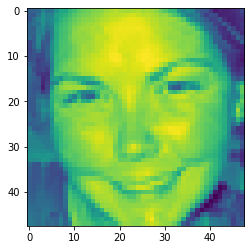

In [92]:
from matplotlib import pyplot as plt
x = faces[8].squeeze()
plt.imshow(x)

In [69]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

In [70]:
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.3,shuffle=True)
xval,xtest,yval,ytest=train_test_split(xtest,ytest,test_size=0.3,shuffle=True)

CNN

In [71]:
def CNN():
    model = Sequential(name='CNN')
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    return model

In [72]:
CNN=CNN()

Training

In [73]:
early_stop = EarlyStopping('val_loss', patience=100)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=25, min_lr=0.00001,model='auto')
trained_models_path = base_path + 'CNN'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]

In [74]:
CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [75]:
CNN_history =CNN.fit(datagen.flow(xtrain, ytrain, batch_size),
          steps_per_epoch=len(xtrain) / batch_size, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks,
          validation_data=(xval,yval))

Epoch 1/50
30/29 [==============================] - ETA: 0s - loss: 2.2524 - accuracy: 0.1783
Epoch 00001: val_loss improved from inf to 1.86224, saving model to models/CNN.01-0.22.hdf5
29/29 [==============================] - 26s 824ms/step - loss: 2.2524 - accuracy: 0.1783 - val_loss: 1.8622 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 2/50
30/29 [==============================] - ETA: 0s - loss: 2.0368 - accuracy: 0.2127
Epoch 00002: val_loss did not improve from 1.86224
29/29 [==============================] - 24s 807ms/step - loss: 2.0368 - accuracy: 0.2127 - val_loss: 1.9281 - val_accuracy: 0.2049 - lr: 0.0010
Epoch 3/50
30/29 [==============================] - ETA: 0s - loss: 1.9590 - accuracy: 0.2179
Epoch 00003: val_loss did not improve from 1.86224
29/29 [==============================] - 24s 806ms/step - loss: 1.9590 - accuracy: 0.2179 - val_loss: 1.9099 - val_accuracy: 0.1493 - lr: 0.0010
Epoch 4/50
30/29 [==============================] - ETA: 0s - loss: 1.9112 - accuracy: 0.

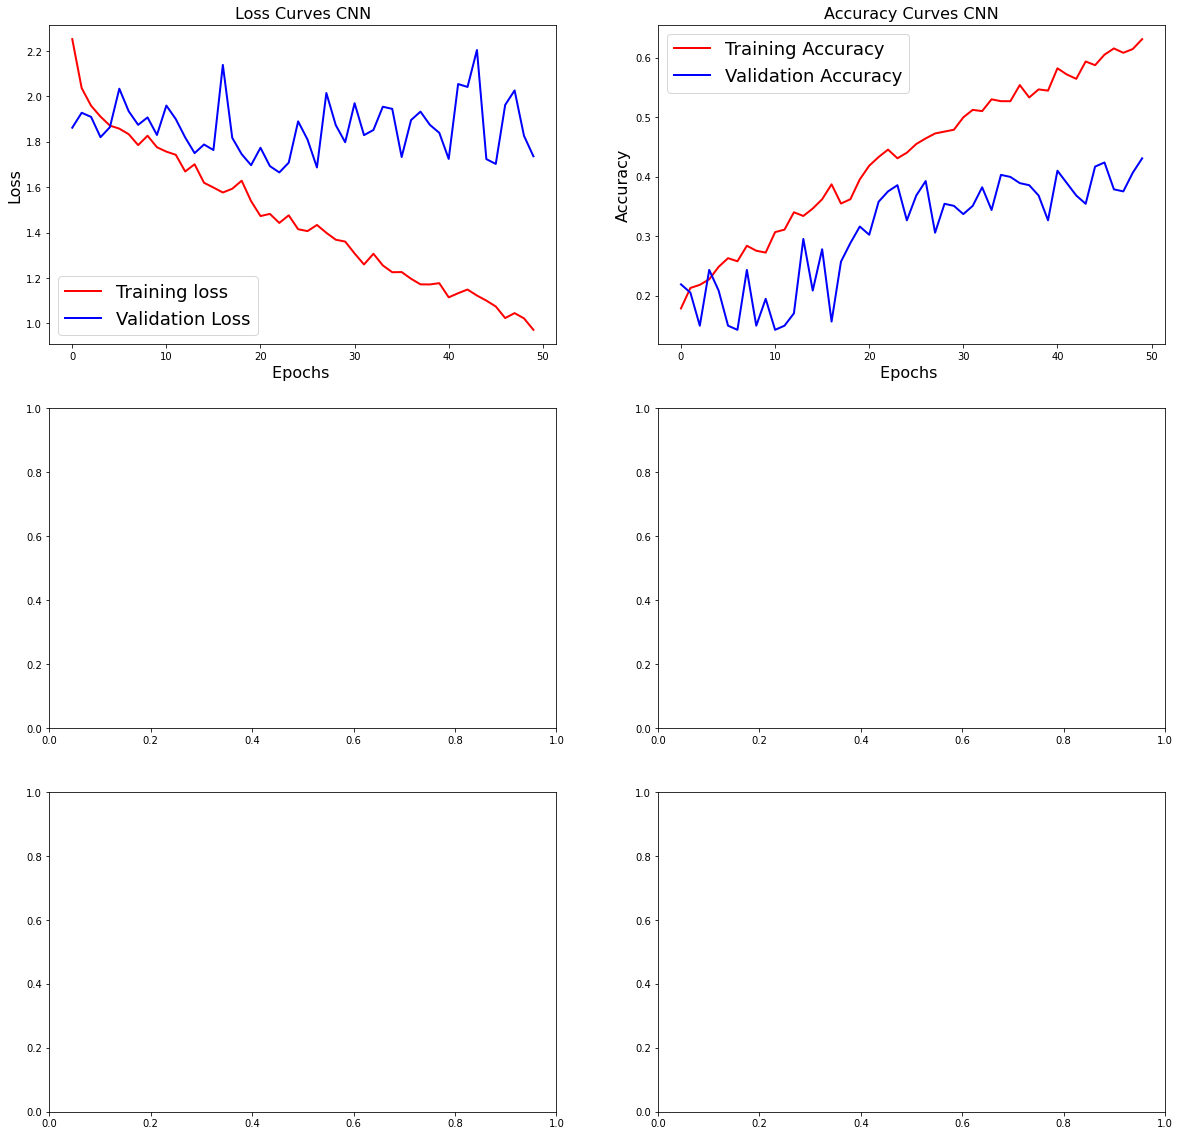

In [77]:
fig,axes=plt.subplots(3,2,figsize=(20, 20))
for (m,history), ax in zip({'CNN':CNN_history}.items(),axes):
    # Loss Curves
    
    ax[0].plot(history.history['loss'],'r',linewidth=2.0)
    ax[0].plot(history.history['val_loss'],'b',linewidth=2.0)
    ax[0].legend(['Training loss', 'Validation Loss'],fontsize=18)
    ax[0].set_xlabel('Epochs ',fontsize=16)
    ax[0].set_ylabel('Loss',fontsize=16)
    ax[0].set_title('Loss Curves '+m,fontsize=16)
 
    # Accuracy Curves
    ax[1].plot(history.history['accuracy'],'r',linewidth=2.0)
    ax[1].plot(history.history['val_accuracy'],'b',linewidth=2.0)
    ax[1].legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    ax[1].set_xlabel('Epochs ',fontsize=16)
    ax[1].set_ylabel('Accuracy',fontsize=16)
    ax[1].set_title('Accuracy Curves '+m,fontsize=16)

In [78]:
  ypred=CNN.predict(xtest)
  ypred_=np.argmax(ypred, axis=1)
  ytest_=np.argmax(ytest, axis=1)
  print(classification_report(ytest_, ypred_,digits=3))

              precision    recall  f1-score   support

           0      0.333     0.304     0.318        23
           1      0.000     0.000     0.000         2
           2      0.273     0.333     0.300        18
           3      0.667     0.667     0.667        24
           4      0.167     0.056     0.083        18
           5      0.647     0.786     0.710        14
           6      0.455     0.600     0.517        25

    accuracy                          0.452       124
   macro avg      0.363     0.392     0.371       124
weighted avg      0.419     0.452     0.428       124



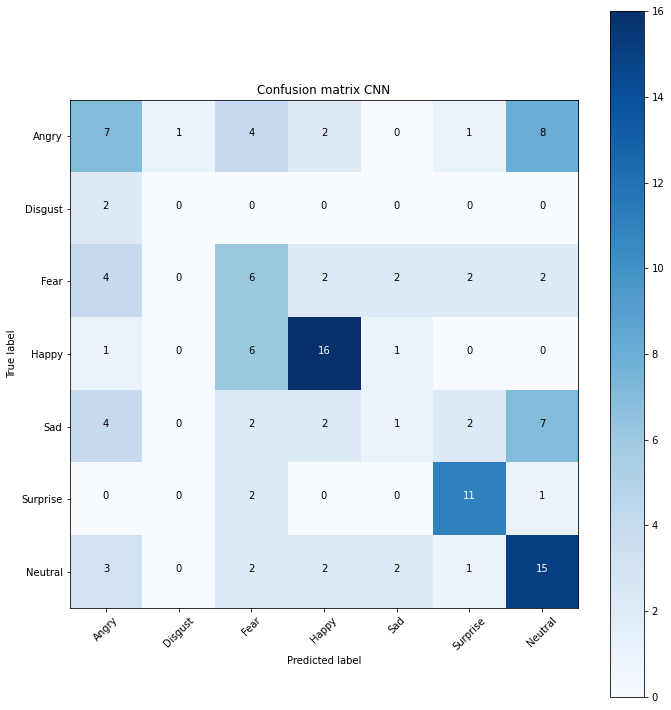

In [79]:
import itertools
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure


fig = figure(figsize=(10, 10))
    
ypred=CNN.predict(xtest)
rounded_predections=np.argmax(ypred, axis=1)

rounded_labels=np.argmax(ytest, axis=1)
cm = confusion_matrix(rounded_labels, rounded_predections)
title='Confusion matrix '+CNN.name
    

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()